# Predicting who survived the Titanic disaster

The [Titanic disaster](https://en.wikipedia.org/wiki/Sinking_of_the_Titanic) doesn't require a lot of introduction. The sinking of the Titanic resulted in the deaths of more than a thousand people, while others survived and were rescued.

It appears that it was not a fully random outcome though who survived and who did not. In this notebook I am going to investigate that, by creating predictive models who survived and who did not, using files with passenger data including information about sex, age, cabin type, and a few more.

I am by no means the first doing this: this challenge is [published in competition format on Kaggle](https://www.kaggle.com/competitions/titanic/overview) and lots of people participate in it, e.g. as part of their endeavors to master data science. 

Which applies to me as well. And while I am certainly keen to make good predictions and get a good spot on the competition's leaderboard, my main goal is to practice my machine learning skills. Such as setting up an efficient process to select features (using RFECV) and hyperparameter tuning (using GridSearchCV). Three models will be used to classify passengers (that is: to predict whether they survived or not): Logistic Regression, K Nearest Neighbor and Random Forest. I already did some initial steps in [Dataquest](https://www.dataquest.io/)'s learning environment, and the result of those steps will be imported in this notebook in one of the first code cells.

The data that is used was downloaded from [Kaggle's Titanic competition page](https://www.kaggle.com/competitions/titanic/data). As explained on that page, there are two passenger files actually. The first one to build your machine learning models, and this one includes for every passenger whether it was a survivor or not. The second does not include that information, and is the file containing passengers to do predictions for. The results of that prediction can then be uploaded onto the Kaggle website, which will then instantly give feedback in the form of a percentage of correct predictions.

Structure of this notebook:
* 1. Preparations and initial data exploration
* 2. Feature engineering
* 3. Feature selection
* 4. Parameter tuning and model selection
* 5. Predict on holdout data, submit to Kaggle
* 6. Conclusions and possible next steps

## 1. Preparations and initial data exploration

Let's import all relevant libraries, import the data and explore it a bit, and do some other preparations.

In [1]:
# Import relevant libraries etc
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV

from datetime import datetime

In [2]:
# Ensure all columns are displayed in the output

pd.set_option('display.max_columns', None)

In [3]:
# Import the data

train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

In [4]:
# Show the size of the train dataset
train.shape

(891, 12)

In [5]:
# Show the size of the holdout dataset
holdout.shape

(418, 11)

In [6]:
# Show a sample of train
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
# Show a sample of holdout
holdout.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


So we have two dataframes now:
* `train` contains the data to build our models (having 891 records)
* `holdout` contains the data that we'll eventually predict for (having 418 records).

They contains exactly the same information, with the column `Survived` being the only difference.
An explanation of all columns can be found [on Kaggle](https://www.kaggle.com/competitions/titanic/data).

## 2. Feature engineering

This section covers all of the work to transform the current data to a format that we want to use for machine learning, including:
* ensuring that all relevant data is in a numerical format
* creating new features based on other columns, e.g. by binning continuous features, or by combining other features
* dummy-coding any categorical features

### 2.1 Import and apply earlier work

In preparation for this project, I already defined (guided by Dataquest) a bunch of helpful functions. They are stored in a file named `functions.py`. Let's use a Magic command to import the contents of this file.

In [8]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

I am slightly unhappy with `create_dummies` as it does not drop one of the generated column. So we will end up with superfluous columns. E.g. we will both get a column `Sex_female` and `Sex_male`, while for some machine learning algorithms it is recommended to only have one of them. Let's create an alternative.

In [9]:
# Create alternative version to create dummies, dropping the first column

def create_dummies_drop_first (df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column, drop first

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name, drop_first = True)
    df = pd.concat([df,dummies],axis=1)
    return df

Let's create a function that can apply all of these functions to a dataframe in one go, apply it to both `train` and `holdout`, and visually check the result.

In [10]:
# Define function to apply all dataframe updates specified above in one go, create dummies for categorical variables, and returns the dataframe

def apply_feature_changes(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    
    # Dummy code the newly added categorical features
    for col in ["Age_categories", "Fare_categories","Title", "Cabin_type", "Sex"]:
        #df = create_dummies(df,col)
        df = create_dummies_drop_first(df,col)
    return df

In [11]:
# Apply feature changes to 'train', and show a sample
train = apply_feature_changes(train)

train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_categories,Fare_categories,Title,Cabin_type,Age_categories_Infant,Age_categories_Child,Age_categories_Teenager,Age_categories_Young Adult,Age_categories_Adult,Age_categories_Senior,Fare_categories_12-50,Fare_categories_50-100,Fare_categories_100+,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Cabin_type_B,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_Unknown,Sex_male
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Young Adult,0-12,Mr,Unknown,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Adult,50-100,Mrs,C,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Young Adult,0-12,Miss,Unknown,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Young Adult,50-100,Mrs,C,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Young Adult,0-12,Mr,Unknown,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1


In [12]:
# Apply feature changes to 'holdout', and show a sample
holdout = apply_feature_changes(holdout)

holdout.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_categories,Fare_categories,Title,Cabin_type,Age_categories_Infant,Age_categories_Child,Age_categories_Teenager,Age_categories_Young Adult,Age_categories_Adult,Age_categories_Senior,Fare_categories_12-50,Fare_categories_50-100,Fare_categories_100+,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Cabin_type_B,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_Unknown,Sex_male
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,Young Adult,0-12,Mr,Unknown,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,Adult,0-12,Mrs,Unknown,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,Senior,0-12,Mr,Unknown,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,Young Adult,0-12,Mr,Unknown,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,Young Adult,12-50,Mrs,Unknown,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0


Looks good!

### 2.2 Explore family-on-board

Above several features of the original data were already 'engineered', some did not get any attention yet. That includes the two features in the data that tell something about whether a passenger had any family members on board:
* `SibSp`: \# of siblings / spouses aboard the Titanic
* `Parch`: \# of parents / children aboard the Titanic

They are numerical columns and can be used in their current format for machine learning as such. However, let's explore them though and see if there is anything to learn that can be of use.

In [13]:
# Column info for both
train[['SibSp','Parch']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 2 columns):
SibSp    891 non-null int64
Parch    891 non-null int64
dtypes: int64(2)
memory usage: 14.0 KB


In [14]:
# Statistics for SibSp
train['SibSp'].describe()

count    891.000000
mean       0.523008
std        1.102743
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        8.000000
Name: SibSp, dtype: float64

In [15]:
train['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [16]:
# Statistics for Parch
train['Parch'].describe()

count    891.000000
mean       0.381594
std        0.806057
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.000000
Name: Parch, dtype: float64

In [17]:
train['Parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

So what we see is that both for SibSp and Parch the most prevalent of values is 0, meaning no sibling/spouses and/or parents/childeren on board at all. But that also for significant amounts of passengers there were family members onboard.

We now want to get insight whether there could be a relationship between the presence of family members and the survival rate. Let's do some calculations and create some graphs for this. We'll both want to see absolute numbers and percentages.

In [18]:
# Get all relevant statistics to draw for SibSp
sibsp_stats = train[['SibSp','Survived']].groupby('SibSp').agg(['count','sum','mean']).reset_index() 
sibsp_stats.columns = ('SibSp','count','survived','survival_fraction')
sibsp_stats['died'] = sibsp_stats['count']-sibsp_stats['survived']
sibsp_stats
                                                                

,SibSp,count,survived,survival_fraction,died
0,0,608,210,0.345395,398
1,1,209,112,0.535885,97
2,2,28,13,0.464286,15
3,3,16,4,0.250000,12
4,4,18,3,0.166667,15
5,5,5,0,0.000000,5
6,8,7,0,0.000000,7


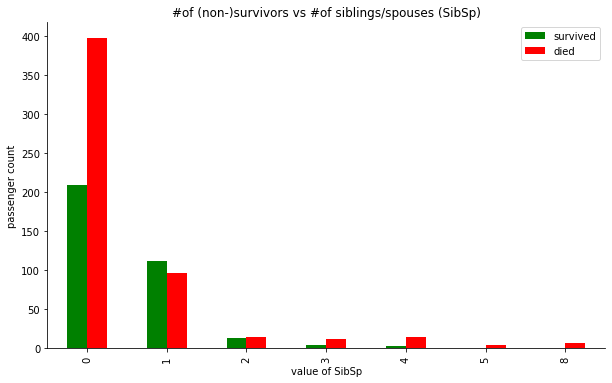

In [19]:
# Plot counts of 'survived' and 'died' for SibSp
sibsp_stats_toplot = sibsp_stats[['survived', 'died']]

ax = sibsp_stats_toplot.plot.bar(color = ['green', 'red'], title = '#of (non-)survivors vs #of siblings/spouses (SibSp)', figsize = (10,6))

ax.set_xticklabels(sibsp_stats['SibSp'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xlabel('value of SibSp')
plt.ylabel('passenger count')
plt.show()

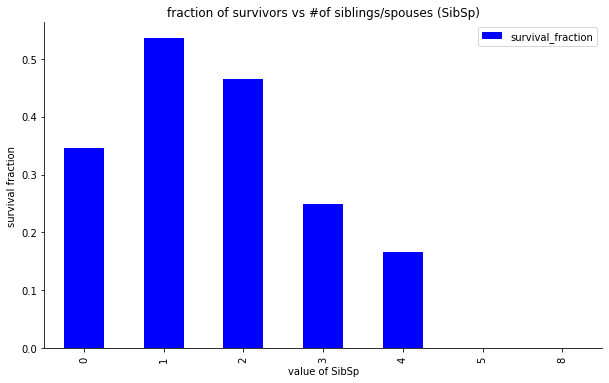

In [20]:
# Plot fraction of 'survived' for SibSp
sibsp_stats_toplot = sibsp_stats[['survival_fraction']]

ax = sibsp_stats_toplot.plot.bar(color = ['blue'], title = 'fraction of survivors vs #of siblings/spouses (SibSp)', figsize = (10,6))

ax.set_xticklabels(sibsp_stats['SibSp'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xlabel('value of SibSp')
plt.ylabel('survival fraction')
plt.show()

Let's do the same for Parch.

In [21]:
# Get all relevant statistics to draw for Parch
parch_stats = train[['Parch','Survived']].groupby('Parch').agg(['count','sum','mean']).reset_index() 
parch_stats.columns = ('Parch','count','survived','survival_fraction')
parch_stats['died'] = sibsp_stats['count']-sibsp_stats['survived']
parch_stats

,Parch,count,survived,survival_fraction,died
0,0,678,233,0.343658,398
1,1,118,65,0.550847,97
2,2,80,40,0.500000,15
3,3,5,3,0.600000,12
4,4,4,0,0.000000,15
5,5,5,1,0.200000,5
6,6,1,0,0.000000,7


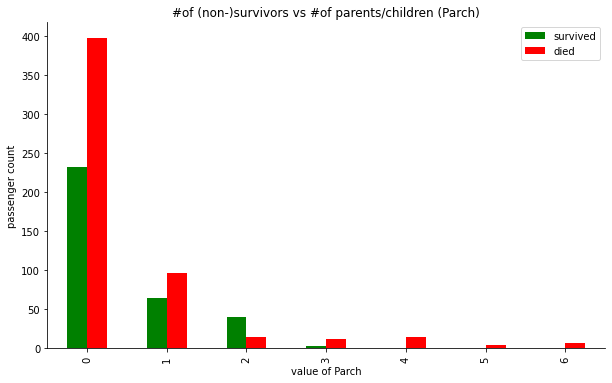

In [22]:
# Plot counts of 'survived' and 'died' for Parch
parch_stats_toplot = parch_stats[['survived', 'died']]

ax = parch_stats_toplot.plot.bar(color = ['green', 'red'], title = '#of (non-)survivors vs #of parents/children (Parch)', figsize = (10,6))

ax.set_xticklabels(parch_stats['Parch'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xlabel('value of Parch')
plt.ylabel('passenger count')
plt.show()

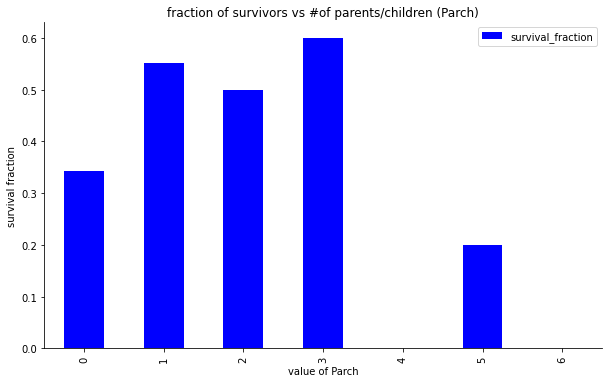

In [23]:
# Plot fraction of 'survived' for Parch
parch_stats_toplot = parch_stats[['survival_fraction']]

ax = parch_stats_toplot.plot.bar(color = ['blue'], title = 'fraction of survivors vs #of parents/children (Parch)', figsize = (10,6))

ax.set_xticklabels(parch_stats['Parch'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xlabel('value of Parch')
plt.ylabel('survival fraction')
plt.show()

The graphs above, in particular the fractions, give the impression that having family members onboard (of either type) increased the chance on survival. As long as there were not too many of them.

What we cannot see yet is whether the passengers having siblings/spouses on board are actually the same as those with parents/children, or whether they are separate groups. And whether we can see even more correlation with survival rates when looking at a total family size. It's not unthinkable, as possibly these family groups acted as 'one group'.

So let's add one feature 'family-size', being the sum of SibSp and Parch, and show the same statistics and graphs for that.

In [24]:
# Add a new column family_members to both datasets (train and test)
train['family_members'] = train['SibSp']+train['Parch']
holdout['family_members'] = holdout['SibSp']+holdout['Parch']

Then, let's create the same graphs as above for this new feature `family_members`, representing the total number of family members.

In [25]:
# Get all relevant statistics to draw for family_members
fam_stats = train[['family_members','Survived']].groupby('family_members').agg(['count','sum','mean']).reset_index() 
fam_stats.columns = ('family_members','count','survived','survival_fraction')
fam_stats['died'] = fam_stats['count']-fam_stats['survived']
fam_stats

,family_members,count,survived,survival_fraction,died
0,0,537,163,0.303538,374
1,1,161,89,0.552795,72
2,2,102,59,0.578431,43
3,3,29,21,0.724138,8
4,4,15,3,0.200000,12
5,5,22,3,0.136364,19
6,6,12,4,0.333333,8
7,7,6,0,0.000000,6
8,10,7,0,0.000000,7


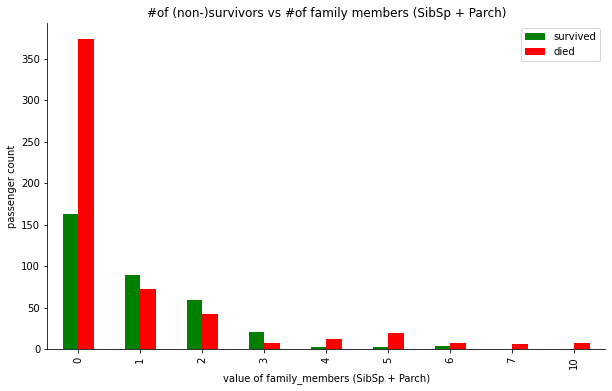

In [26]:
# Plot counts of 'survived' and 'died' for family_members
fam_stats_toplot = fam_stats[['survived', 'died']]

ax = fam_stats_toplot.plot.bar(color = ['green', 'red'], title = '#of (non-)survivors vs #of family members (SibSp + Parch)', figsize = (10,6))

ax.set_xticklabels(fam_stats['family_members'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xlabel('value of family_members (SibSp + Parch)')
plt.ylabel('passenger count')
plt.show()

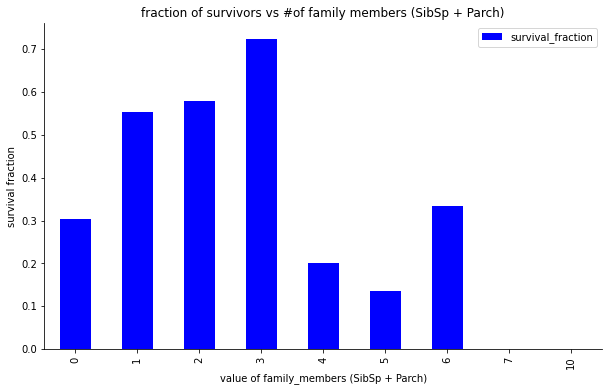

In [27]:
# Plot fraction of 'survived' for family_members
fam_stats_toplot = fam_stats[['survival_fraction']]

ax = fam_stats_toplot.plot.bar(color = ['blue'], title = 'fraction of survivors vs #of family members (SibSp + Parch)', figsize = (10,6))

ax.set_xticklabels(fam_stats['family_members'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xlabel('value of family_members (SibSp + Parch)')
plt.ylabel('survival fraction')
plt.show()

The pattern is more or less the same as for the individual ones, but it seems to confirm that:
* having 0 family members: relatively low chance of survival
* having 1-3 family members: relatively high change of survival
* having 4 or more family members: relatively low chance of survival

We can go multiple directions with this. The graphs are not fully convincing that family-members-total is more interesting than the individual SibSp and Parch columns. And if we decide to use this new feature, a question is still whether to use it in this format, or whether to make categories out of it. And if we do that: which categories.

Let's do the following:
* in addition to the new feature `family_members`, let's also add a categorized version of it
* with three categories: 0 family members, 1-3 family members and 4+ family members; as that is the pattern that we see from the graph
* then during feature selection we can still figure which of these to use.

In [28]:
# Create a function that returns family_size_category:
def set_family_size_category(row):
    if row['family_members']==0:
        return 'no_family'
    elif row['family_members'] > 3:
        return 'large_family'
    else:
        return 'small_family'

In [29]:
# Apply to train, dummy-code, and check the result

train['fam_size_cat'] = train.apply(set_family_size_category, axis=1)
train = create_dummies_drop_first(train,'fam_size_cat')

train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_categories,Fare_categories,Title,Cabin_type,Age_categories_Infant,Age_categories_Child,Age_categories_Teenager,Age_categories_Young Adult,Age_categories_Adult,Age_categories_Senior,Fare_categories_12-50,Fare_categories_50-100,Fare_categories_100+,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Cabin_type_B,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_Unknown,Sex_male,family_members,fam_size_cat,fam_size_cat_no_family,fam_size_cat_small_family
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Young Adult,0-12,Mr,Unknown,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,small_family,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Adult,50-100,Mrs,C,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,small_family,0,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Young Adult,0-12,Miss,Unknown,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,no_family,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Young Adult,50-100,Mrs,C,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,small_family,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Young Adult,0-12,Mr,Unknown,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,no_family,1,0
5,6,0,3,"Moran, Mr. James",male,-0.5,0,0,330877,8.4583,Q,Missing,0-12,Mr,Unknown,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,no_family,1,0
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,S,Adult,50-100,Mr,E,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,no_family,1,0
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,S,Infant,12-50,Master,Unknown,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,4,large_family,0,0
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,S,Young Adult,0-12,Mrs,Unknown,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,2,small_family,0,1
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,C,Teenager,12-50,Mrs,Unknown,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,small_family,0,1


Looks good, let's apply to holdout as well.

In [30]:
# Apply to holdout, dummy-code

holdout['fam_size_cat'] = holdout.apply(set_family_size_category, axis=1)
holdout = create_dummies_drop_first(holdout,'fam_size_cat')

### 2.3 Validate dataframes

Before we move on with feature selection, let's double-check whether `train` and `holdout` still have the same columns (apart from the `Survived` column). Or, to be frank: much later on, I got error messages when trying to create predictions for the holdout file, and figured out that this was caused by a difference in columns. Addressing that here.

In [31]:
# Get the current columns of both dataframes, and show the difference
traincolumns = train.columns.tolist()
holdoutcolumns = holdout.columns.tolist()
thediff = set(traincolumns).symmetric_difference(holdoutcolumns)
print(list(thediff))

['Survived', 'Cabin_type_T']


So next to `Survived` there is another difference. Let's investigate. This column `Cabon_type_T` was derived from the original column `Cabin_type`.

In [32]:
# Show Cabin_types for train
train['Cabin_type'].value_counts()

Unknown    687
C           59
B           47
D           33
E           32
A           15
F           13
G            4
T            1
Name: Cabin_type, dtype: int64

In [33]:
# Show Cabin_types for holdout
holdout['Cabin_type'].value_counts()

Unknown    327
C           35
B           18
D           13
E            9
F            8
A            7
G            1
Name: Cabin_type, dtype: int64

Right. So Cabin type 'T' occurred in the train data once, and not at all in the holdout data. And with the code above that means that during dummy-coding a column `Cabin_type_T` was never created for holdout.

It is not the most elegant solution maybe, but let's just add this column to holdout as well, and fill it with 0 completely (expressing that no one had Cabin type 'T'). It should do the job.

In [34]:
# Add missing column to holdout
holdout['Cabin_type_T']=0

In [35]:
# Double check result: once more get the current columns of both dataframes, and show the difference
traincolumns = train.columns.tolist()
holdoutcolumns = holdout.columns.tolist()
thediff = set(traincolumns).symmetric_difference(holdoutcolumns)
print(list(thediff))

['Survived']


Looks good now.

## 3. Feature selection

We now have many features to use for a predictive model. Next step is to select a subset of features to use for prediction. Domain knowledge (or in this case: common sense), analysis of correlations between features and some trial-and-error could probably get us somewhere. Instead, I am going to use [scikit-learn's RFECV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html) (Recursive feature elimination with cross-validation) to select features.

We will do that separately for Logistic Regression and Random Forest, as it is not said that for both of them the same features are the best predictors.

RFECV does not support KNN however, so for KNN we need to come up with something else.

### 3.1 Feature selection for Logistic Regression and Random Forest

Let's create the function to do feature selection using RFECV.

We'll start with all numerical columns apart from `PassengerId` which doesn't make sense to use. Then we'll let RFECV do the heavy work of trying different feature sets, using 10-fold cross validation to assess the results.

One thing that I am wondering, is till what extent we should actually drop the 'originals' of columns that we feature-engineered into something else. E.g. should we keep `Age` now we also added the various `Age_categories_` features? Same question for `Fare`. And we have a lot of features around family members now, absolute numbers and categories, separate for SibSp and Parch and for the combination of them.

For now, let's use make it an input parameter of our function whether or not to drop the original columns upfront, being:
* Age
* Fare
* SibSp
* Parch
* family_members

In [36]:
# Define function to perform feature selection (using RFECV) for Logistic Regression and Random Forest
# (Commented out: For KNN simply return all (numerical) features)

def select_features(df, ignore_categorized_features = False):
    # Remove any columns with null values
    df = df.dropna()
    
    # Remove any non-numeric columns (having checked which types we have)
    numerics = ['int64', 'float64', 'uint8']
    df = df.select_dtypes(include=numerics)
    
    # Get feature columns and target column
    feature_columns = df.columns.to_list()
    feature_columns.remove('PassengerId')
    feature_columns.remove('Survived')
    target_column = 'Survived'
    
    # Depending on input parameter, ignore the original features that were used to engineer new features
    if ignore_categorized_features == True:
        feature_columns.remove('Age')
        feature_columns.remove('Fare')
        feature_columns.remove('SibSp')
        feature_columns.remove('Parch')
        feature_columns.remove('family_members')
        
    print('Number of candidate features:', len(feature_columns))
    # Select data based on columns
    all_X = df[feature_columns]
    all_y = df[target_column]
    
    # print(all_X.shape)
    # print(all_y.shape)
    
    # ### LOGISTIC REGRESSION
    print('Selecting features for LogisticRegression...')

    # Instantiate Logistic Regression estimator
    lr = LogisticRegression(solver = 'lbfgs', max_iter = 1000, random_state = 0)

    # Instantiate selector instance (use cross-fold validation with 10 folds)
    selector = RFECV(lr,cv=10, n_jobs=-1) # use all cores
    
    # Perform recursive feature elimination 
    selector.fit(all_X,all_y)
    
    # Get optimized columns
    optimized_columns_lr = all_X.columns[selector.support_]
    
    # Print number of selected features
    print('Number of features returned by RFECV for LR:', len(optimized_columns_lr))

    # ### K NEAREST NEIGHBORS
    #print('Selecting features for K Nearest Neighbors (= use all numeric features)...')
    #optimized_columns_knn = feature_columns
    
    # Print number of selected features
    #print('Number of features returned for KNN:', len(optimized_columns_knn))
    
    # ### RANDOM FOREST CLASSIFIER
    print('Selecting features for RandomForestClassifier...')
   
    # Instantiate RandomForestClassifier estimator
    rfc = RandomForestClassifier(n_estimators = 10, random_state = 0)
    
    # Instantiate selector instance (use cross-fold validation with 10 folds)
    selector = RFECV(rfc,cv=10, n_jobs=-1) # use all cores
    
    # Perform recursive feature elimination 
    selector.fit(all_X,all_y)
    
    # Get optimized columns
    optimized_columns_rfc = all_X.columns[selector.support_]
    
    # Print number of selected features
    print('Number of features returned by RFECV for RFC:', len(optimized_columns_rfc))
    
    # Return optimized columns
    return optimized_columns_lr, optimized_columns_rfc

In [37]:
# Run RFECV feature selection on the train dataset
selected_features_lr, selected_features_rfc = select_features(train)

Number of candidate features: 31
Selecting features for LogisticRegression...
Number of features returned by RFECV for LR: 14
Selecting features for RandomForestClassifier...
Number of features returned by RFECV for RFC: 7


So we see that (out of 31 candidates), 14 features were selected for Logistic Regression and 7 for Random Forest.
Let's take a look which ones.

In [38]:
# Show features selected by RFECV
print ('Selected features LogisticRegression:', selected_features_lr)
print ('\n Selected features RandomForestClassifier:', selected_features_rfc)

Selected features LogisticRegression: Index(['Pclass', 'Age_categories_Infant', 'Age_categories_Adult',
       'Age_categories_Senior', 'Title_Mr', 'Title_Mrs', 'Title_Officer',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_G', 'Cabin_type_Unknown',
       'Sex_male', 'fam_size_cat_no_family', 'fam_size_cat_small_family'],
      dtype='object')

 Selected features RandomForestClassifier: Index(['Pclass', 'Age', 'Fare', 'Title_Mr', 'Cabin_type_Unknown', 'Sex_male',
       'family_members'],
      dtype='object')


Interesting to see that for Logistic Regression we see a tendency that categories (results of dummy-coding) have been selected, while for Random Forest the underlying continuous variables were used a bit more.

Now let's also run while excluding upfront those (numerical) features that were used to create other features.

In [39]:
# Run RFECV feature selection on the train dataset, ignore features that have been categorized during feature engineering
selected_features_lr_io, selected_features_rfc_io = select_features(train, ignore_categorized_features = True)

Number of candidate features: 26
Selecting features for LogisticRegression...
Number of features returned by RFECV for LR: 6
Selecting features for RandomForestClassifier...
Number of features returned by RFECV for RFC: 20


In [40]:
# Show features selected by RFECV, when upfront ignoring those that were categorized
print ('Selected features LogisticRegression (when ignoring categorized ones): \n', selected_features_lr_io)
print ('\n Selected features RandomForestClassifier (when ignoring categorized ones): \n', selected_features_rfc_io)

Selected features LogisticRegression (when ignoring categorized ones): 
 Index(['Pclass', 'Age_categories_Infant', 'Title_Mr', 'Title_Officer',
       'fam_size_cat_no_family', 'fam_size_cat_small_family'],
      dtype='object')

 Selected features RandomForestClassifier (when ignoring categorized ones): 
 Index(['Pclass', 'Age_categories_Infant', 'Age_categories_Child',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Fare_categories_12-50', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Officer', 'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D',
       'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_male',
       'fam_size_cat_no_family', 'fam_size_cat_small_family'],
      dtype='object')


Observations:
* for Logistic Regression, originally 14 were selected and now only 6. Even a lot of features that are actually available still are suddenly not part of the selection anymore! 
* for RandomForest, originally 7 features were selected, and now we have 20. That is less surprising as by dropping features like `Age` or `family_members` as possibilities, it went for the categorized versions instead.

The result is remarkable, in particular for Logistic Regression. The only explanation that I have is that score differences between different feature selections are very small and that just another turn was made somewhere by RFECV. (Or I just made a mistake that I am overlooking.)

It makes it not so straightforward to conclude which features to use really.

To add to this: I did a bit more experiments (of which I have not included the results here), and observed that also parameters like `n_estimators` (for Random Forest) and even `random_state` have a significant outcome on the result. 

It seems to imply there is no definite best answer here, and we should just make a choice.

Let's continue with those that were selected by the initial RFECV runs (those that started from all candidate features without eliminitating any upfront). After all, there is no reason to decidee ourselves that the self-engineered features are better predictors than the original ones that they were based on, if the numbers say something different.

### 3.2 Feature selection for K Nearest Neighbors

As mentioned above, for KNN RFECV cannot be used to select features. One alternative would be to use all (numerical) features for KNN and leave it to the predictive model as such. That seems not to be a good strategy though, as having irrelevant features in the selection can actually deteriorate results for KNN. (I did some experiments with it actually, results not document here, and indeed using all features for KNN didn't appear to be a good choice.)

We could do an extensive search with other methods, but for now let's keep it simple. We'll take several categories of which we learned above that they really seem relevant. And we should not use continuous features like `Age` as we did not scale them. 

In [41]:
# Set selected features for knn
selected_features_knn =['Pclass', 'Age_categories_Infant', 'Cabin_type_Unknown', 'Sex_male', 'fam_size_cat_no_family']

# Note that `selected_features_knn` is a list, while the other two selections are something with Index
# It doesn't seem to matter for the next steps; apparently both kan be handled, so I leave it like this.

Now this may actually be too simplistic. `PClass` has values 1, 2 and 3 and should better be changed to dummy categories (values 0 and 1) as well since all others are so despite its relevance it may have too much influence now. And maybe these are simply not enough, or too simple categories.

Let's go for this now though, and in particular if we see good initial results for KNN we can revisit this.



## 4. Parameter tuning and model selection

We now have selected features to use for predictive models for:
* Logistic Regression
* K Nearest Neighbors classifier
* Random Forest classifier

Each of these models comes with a bunch of hyper-parameters though, the values of which can have significant impact on the model accuracy.

In this section we are going to tune these parameters, using our training dataset. We can do that efficiently using [scikit-learn's GridSearchCV class](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). This will tune all parameters within pre-specified ranges, and applies cross-validation to assess the model's accuracy for each combination of hyper-parameters that it tries.

After that, we have 3 tuned models (LR, KNN, RFC) and for each of them we will know how well it performed on the training dataset itself (with cross-validation). We can then select the best one of these.

In [42]:
# Define function to perform model selection including hyperparameter tuning (using GridSearchCV), for 3 estimators

# Note: this could be more elegantly parameterized, e.g. it is rather arbitrary that the dataframe is an input parameter
# but the features to use are not. It does the job though, so leave it for now.

def select_model(df):
    
    # Initiate a list of dictionaries, each element containing a model name, its estimator, the features to use for it,
    # and d a dictionary of hyperparameters with possible values
    model_dict = [
                   {
                     "name": "LogisticRegression",
                     "estimator": LogisticRegression(),
                     "features": selected_features_lr,  # bit ugly to use a variable that was set earlier, but it works
                     "hyperparameters":
                        {
                          "solver": ["newton-cg", "lbfgs", "liblinear"],
                          "max_iter": [1000] #added this to avoid non-convergence warnings
                        }
                   },
                   {
                     "name": "KNeighborsClassifier",
                     "estimator": KNeighborsClassifier(),
                     "features": selected_features_knn,  # bit ugly to use a variable that was set earlier, but it works
                     "hyperparameters":
                        {
                          "n_neighbors": range(1,20,2),
                          "weights": ["distance", "uniform"],
                          "algorithm": ["ball_tree", "kd_tree", "brute"],
                          "p": [1,2]
                        }
                   },
                 {
                     "name": "RandomForestClassifier",
                     "estimator": RandomForestClassifier(),
                     "features": selected_features_rfc,  # bit ugly to use a variable that was set earlier, but it works
                     "hyperparameters":
                        {
                          "n_estimators": [4, 6, 9],
                          "criterion": ["entropy", "gini"],
                          "max_depth": [2, 5, 10],
                          "max_features": ["log2", "sqrt"],
                          "min_samples_leaf": [1, 5, 8],
                          "min_samples_split": [2, 3, 5]
                        }
                    }       
                 ]
    
    # Iterate over models and for each perform grid search, then store and print relevant results
    for model in model_dict:
        # Print model name
        print(model['name'])

        # Instantiate estimator and hyperparameters
        estimator = model['estimator']
        params = model['hyperparameters']
        
        # Instantiate grid search object
        grid = GridSearchCV(estimator, param_grid = params, cv=10, iid= None)

        #Create data to use
        all_X = df[model['features']]
        all_y = df['Survived']
        
        # Fit the grid search instance model (= train and tune hyperparameters)
        grid.fit(all_X, all_y)
        
        # Store best parameters, best score and model belonging to it in dictionary
        model['best_params'] = grid.best_params_
        model['best_score'] = grid.best_score_
        model['best_estimator'] = grid.best_estimator_
        
        # Print best parameters and score
        print('Best parameters:', grid.best_params_)
        print('Best score:', grid.best_score_)
        
                
    # Return result: the dictionary of models, now including the result
    return model_dict

Let's call this function, and immediately see the outcome of the parameter tuning, and the corresponding cross-validation scores.

In [43]:
# Run the model selection function (using the train dataset) to select a model and tune hyper-parameters
model_selection = select_model(train)

LogisticRegression
Best parameters: {'max_iter': 1000, 'solver': 'newton-cg'}
Best score: 0.8283231188287369
KNeighborsClassifier
Best parameters: {'algorithm': 'brute', 'n_neighbors': 19, 'p': 2, 'weights': 'distance'}
Best score: 0.8193085347860629
RandomForestClassifier
Best parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 4}
Best score: 0.8418320848938826


Interesting. Let's take a more detailed look at all the information: the full dictionary with inputs and results.

In [44]:
# Print all results (the full dictionary with inputs and results)
model_selection

[{'name': 'LogisticRegression',
  'estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=100,
                     multi_class='warn', n_jobs=None, penalty='l2',
                     random_state=None, solver='warn', tol=0.0001, verbose=0,
                     warm_start=False),
  'features': Index(['Pclass', 'Age_categories_Infant', 'Age_categories_Adult',
         'Age_categories_Senior', 'Title_Mr', 'Title_Mrs', 'Title_Officer',
         'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_G', 'Cabin_type_Unknown',
         'Sex_male', 'fam_size_cat_no_family', 'fam_size_cat_small_family'],
        dtype='object'),
  'hyperparameters': {'solver': ['newton-cg', 'lbfgs', 'liblinear'],
   'max_iter': [1000]},
  'best_params': {'max_iter': 1000, 'solver': 'newton-cg'},
  'best_score': 0.8283231188287369,
  'best_estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=Tr

The accuracies (of 10-fold cross-validation on the training dataset) are:
* Logistic Regression: 82.8%
* K Nearest Neighbors: 81.9%
* Random Forest: 84.2%

Random Forest appears to be the winner, but arguably we could conclude as well say that this is 'too close to call'.

When looking at the tuned values of the hyper-parameters, one observation is that in particular for Random Forest the maximum value was selected that was offered as input in the first place: max_depth = 10 and n_estimators = 9. Raising the question whether results could be improved still when allowing the grid-search larger values. I have actually tried with max_depth = 15 and n_estimators = 20 instead, but it did not improve the results. (The score even went down to 84.1%.)

So let's consider these our 'best models' for the three different predictive models.

## 5. Predict on holdout data, submit to Kaggle

Now we have a trained and tuned models, we can use them to predict on the 'holdout data' (the one that we actually need to do predictions for), and create a .csv file with the results that can be submitted to Kaggle.

Let's first create a function to create predictions and store them in a .csv file in the desired format.

In [45]:
# Define function to predict on the holdout data and save Kaggle submission file

def save_submission_file(trained_model, features, filename = 'titanic_predictions_kaggle.csv'):
    
    # Predict on holdout data
    holdout_predictions = trained_model.predict(holdout[features])
    
    # Create file in expected structure
    holdout_ids = holdout["PassengerId"]
    submission_df = {"PassengerId": holdout_ids, "Survived": holdout_predictions}
    submission = pd.DataFrame(submission_df)

    submission.to_csv(filename, index=False)

Given that the results for the three different models (Logistic Regression, K Nearest Neighbors, Random Forest) were quite similar, let's just run this for all three anyway. So we generate three files to submit to Kaggle (that we can distinguish by their file names.)

In [46]:
# Get current date-time to add to filename
rightnow = datetime.now().strftime("%Y%m%d-%H%M%S")

# ### Logistic Regression

# Select best performing model
lr_model = [d['best_estimator'] for d in model_selection if d['name']=='LogisticRegression'][0]
# Create file name
filename = 'predictions_lr_' + rightnow + '.csv'
# Run function to calculate and save file
save_submission_file(lr_model, selected_features_lr, filename)

# K Nearest Neighbors Classifier

# Select best performing model
knn_model = [d['best_estimator'] for d in model_selection if d['name']=='KNeighborsClassifier'][0]
# Create file name
filename = 'predictions_knn_' + rightnow + '.csv'
# Run function to calculate and save file
save_submission_file(knn_model, selected_features_knn, filename)

# ### Random Forest Classifier

# Select best performing model 
rfc_model = [d['best_estimator'] for d in model_selection if d['name']=='RandomForestClassifier'][0]
# Create file name
filename = 'predictions_rfc_' + rightnow + '.csv'
# Run function to calculate and save file
save_submission_file(rfc_model, selected_features_rfc, filename)

I submitted all three files to Kaggle. Let's show the result here.

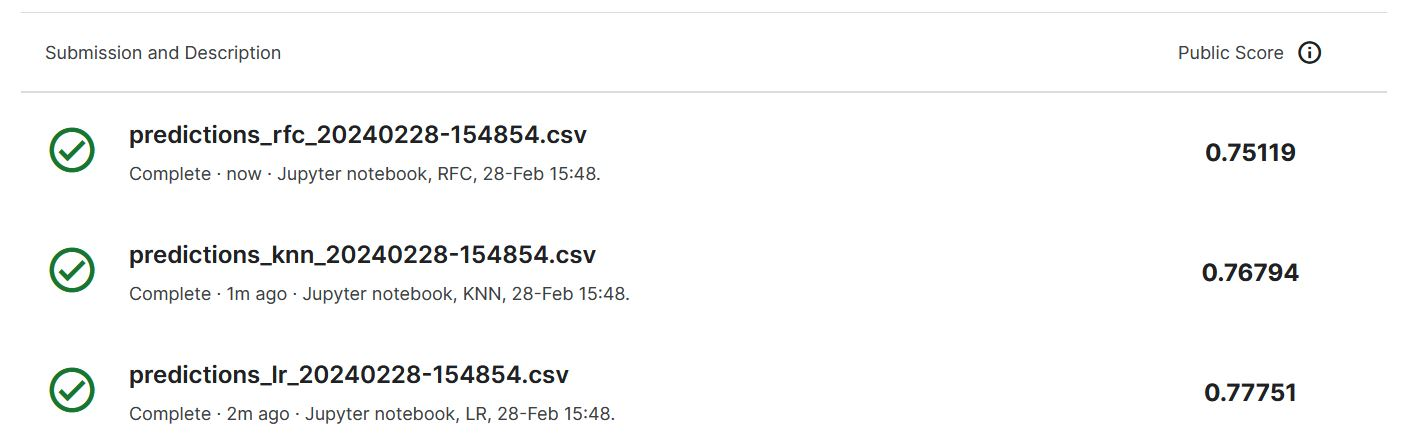

Let collect the results in a table, both the cross-validation scores on the train dataset and the results on the holdout dataset.

In [47]:
%%html
<style>
table {float:left}
</style>

|Model|Accuracy train|Accuracy holdout|
|---|---|---|
|Logistic Regression|82.83%|77.75%|
|K Nearest Neighbor|81.93%|76.79%|
|Random Forest| 84.29% |75.12%|

Observations:
* All models seem to be prone to overfitting, as the accuracy on the holdout dataset is quite a bit lower than on the train dataset (cross-validation score)
* The Random Forest model that looked most promising actually did worst when predicting on the holdout dataset
* The Logistic Regression model performed best on the holdout data

## 6. Conclusions and possible next steps

Conclusions:
* Predictions with Logistic Regression, K Nearest Neighbor and Random Forest are all doing similarly well: while the results are not identical, they are all in the same range.
* All models overfit.
* Small differences in input parameters of the methods used (such as RCEFV and GridSearchCV) can give quite different outcomes, e.g. different feature selections. That does not appear to have massive impact on the predictions at the end, both for the cross-validation scores on the training data and for the holdout data.

The impression that I get is that there are some key features that really make the difference, and that with a lot of feature engineering, model tuning etc. maybe some, but not massive improvements can be made actually. Having read some posts on Kaggle about this competition seem to confirm that. 

Next steps could be:
* For the models developed in the model, more advanced feature selection and hyper parameter tuning might still give some improvements.
* Continue with feature engineering: study patterns in the data and translate them in new features.
* Try out different models.